In [1]:
import xarray as xr
import numpy  as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

弃用的历史版本
绘制MPAS输出降水的时间序列，和CMORPH之间的对应，以及误差；便于说明问题绘制了分位数图
是此前绘制的未经过MASK的版本，CMORPH和CN05.1接近，最后保留了此前逐年绘制CMORPH的版本

In [7]:
year = "2006"
dir_vr = "/raid52/yycheng/MPAS/VR_postprocess/VR_merge/pre/" + "daily_pre_"+year+".nc"
ds_vr = xr.open_dataset(dir_vr)
# ds_vr

dir_rcm = "/raid52/yycheng/MPAS/RCM_postprocess/RCM_merge/pre/" + "daily_pre_"+year+".nc"
ds_rcm = xr.open_dataset(dir_rcm)
# ds_rcm

obs_cmorph = "/raid52/yycheng/MPAS/REFERENCE/CMORPH/DAILY/cdo_merge_daily/" + "CMORPH_"+ year +"_04-08_sellonlat.nc"
ds_cmorph = xr.open_dataset(obs_cmorph)

obs_cn051  = "/raid52/yycheng/MPAS/REFERENCE/CN05.1/1961-2014/" + "sel_CM05.1.nc"
ds_cn051 = xr.open_dataset(obs_cn051)

# ds_cmorph
# precip_obs = ds_disk["precip_CMORPH"]
# precip_mod = ds_disk["precip_MPAS"]
vr_mean     = ds_vr['precip_MPAS'].mean(dim=["longitude","latitude"])
rcm_mean    = ds_rcm['precip_MPAS'].mean(dim=["longitude","latitude"])
cmorph_mean = ds_cmorph['cmorph'].mean(dim=["lon","lat","lev"]) # remove single dimension
cn051_mean  = ds_cn051['pre'].sel(time=year).mean(dim=['lon','lat'])


<xarray.DataArray 'pre' (time: 153, lat: 160, lon: 280)>
[6854400 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2006-04-01 2006-04-02 ... 2006-08-31
  * lon      (lon) float32 70.125 70.375 70.625 ... 139.375 139.625 139.875
  * lat      (lat) float32 15.125 15.375 15.625 15.875 ... 54.375 54.625 54.875
Attributes:
    long_name:  CN05.1 daily, precipitation,mm/day                           ...

In [46]:
# test date select
# ds_vr['precip_MPAS'].Time[(ds_vr.Time.dt.month>=5) & (ds_vr.Time.dt.month<=7)]
time_idx = pd.date_range(start = "2006-04", end = "2006-08",freq='m')
# time_idx
ds_vr.sel(Time = time_idx)

<xarray.Dataset>
Dimensions:      (Time: 4, latitude: 160, longitude: 280)
Coordinates:
  * Time         (Time) datetime64[ns] 2006-04-30 2006-05-31 ... 2006-07-31
  * latitude     (latitude) float32 15.124999 15.374997 ... 54.624992 54.874992
  * longitude    (longitude) float32 70.124985 70.37499 ... 139.62498 139.87498
Data variables:
    precip_MPAS  (Time, latitude, longitude) float64 0.001443 ... 0.01215
    precip_grid  (Time, latitude, longitude) float64 ...
    precip_conv  (Time, latitude, longitude) float64 ...

In [22]:
df_cmorph = cmorph_mean.to_dataframe()
df_vr  = vr_mean.to_dataframe()
df_rcm = rcm_mean.to_dataframe()
# rename df
df_vr  = df_vr.rename(columns={"precip_MPAS":"pre_vr"})
df_rcm = df_rcm.rename(columns={"precip_MPAS":"pre_rcm"})


vr_error_value = np.squeeze(df_vr.values - df_cmorph.values) # 去掉冗余的维度
vr_error       = pd.Series(vr_error_value,index=df_cmorph.index,name = 'VR - CMORPH')

rcm_error_value = np.squeeze(df_rcm.values - df_cmorph.values) # 去掉冗余的维度
rcm_error       = pd.Series(rcm_error_value,index=df_cmorph.index,name = 'RCM - CMORPH')
# obs_mean_dict = {}
pd_plot = pd.concat([df_cmorph, df_vr, df_rcm], axis=1)
pd_plot.head()

,cmorph,pre_vr,pre_rcm
2006-04-01,1.361068,1.953740,1.909396
2006-04-02,0.944151,1.566098,1.540581
2006-04-03,0.989204,1.591061,1.507027
2006-04-04,1.765509,2.714027,2.775311
2006-04-05,0.971169,1.993098,1.888013


Text(0.5, 1.0, '2006')

<Figure size 432x432 with 0 Axes>

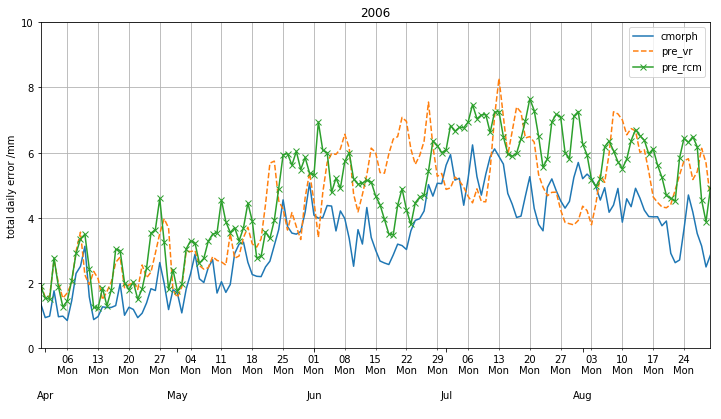

In [8]:
import matplotlib.dates as dates
# pd_plot = pd.concat([df_obs, df_mod,minus], axis=1)
plt.figure(figsize=(6,6))

ymin = 0.
ymax = 10.
idx = pd.date_range(year+'-04-01', year+'-09-01')
# s = pd.Series(np.random.randn(len(idx)), index=idx)

# fig, ax = plt.subplots()
# ax.plot_date(idx.to_pydatetime(), 'v-')
ax = pd_plot.plot(figsize=(12,6),style=['-','--','x-'])
ax.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0),
                                                interval=1))
ax.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
ax.xaxis.grid(True, which="minor")
ax.yaxis.grid()
ax.xaxis.set_major_locator(dates.MonthLocator())
ax.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n'))
# ax.set_xlim([xmin,xmax])
ax.set_ylim([ymin,ymax])
# plt.tight_layout()
# plt.show()
ax.set_ylabel("total daily error /mm")
plt.title(year)
# plt.savefig("./output_pic/precip_check_timeseries/"+year+"_time_series.png")

下面是旧代码，按照相似的方式重构出来

In [2]:
year = "2003"
diri = "/m2data2/yycheng/yycheng/MPAS/92-25km_VR_"+year+"/postprocess/temp_data/"
fili = year+"_daily_precip_combine_CMORPH_MPAS.nc"
ds_disk = xr.open_dataset(diri + fili)
ds_disk

<xarray.Dataset>
Dimensions:        (Time: 153, lat: 160, latitude: 160, lon: 320, longitude: 320, time: 153)
Coordinates:
  * time           (time) datetime64[ns] 2003-04-01 2003-04-02 ... 2003-08-31
  * lat            (lat) float32 15.125 15.375 15.625 ... 54.375 54.625 54.875
  * lon            (lon) float32 60.125 60.375 60.625 ... 139.625 139.875
  * Time           (Time) datetime64[ns] 2003-04-01 2003-04-02 ... 2003-08-31
  * latitude       (latitude) float32 15.124999 15.374997 ... 54.874992
  * longitude      (longitude) float32 60.124992 60.374996 ... 139.87498
Data variables:
    precip_CMORPH  (time, lat, lon) float32 ...
    precip_MPAS    (Time, latitude, longitude) float64 ...
    precip_grid    (Time, latitude, longitude) float64 ...
    precip_conv    (Time, latitude, longitude) float64 ...

In [3]:
precip_obs = ds_disk["precip_CMORPH"]
precip_mod = ds_disk["precip_MPAS"]
obs_mean = precip_obs.mean(dim=["lon","lat"])
mod_mean = precip_mod.mean(dim=["longitude","latitude"])

In [4]:
# test = ds_disk.data_vars.keys()
# ds_disk[list(test)[1]]
test = dict(ds_disk.data_vars)
# test.get('precip_CMORPH')

In [5]:
df_obs = obs_mean.to_dataframe()
df_mod = mod_mean.to_dataframe()
# df_total_error = df_obs - df_mod
test   = np.squeeze(df_obs.values - df_mod.values) # 去掉冗余的维度
minus  = pd.Series(test,index=df_obs.index,name = 'CMORPH - MPAS')
# obs_mean_dict = {}


In [6]:
pd_plot = pd.concat([df_obs, df_mod, minus], axis=1)
pd_plot.head()

,precip_CMORPH,precip_MPAS,CMORPH - MPAS
2003-04-01,1.336223,2.057569,-0.721346
2003-04-02,0.855864,1.701747,-0.845883
2003-04-03,0.891684,1.423617,-0.531933
2003-04-04,1.263897,1.964623,-0.700726
2003-04-05,0.631369,1.247780,-0.616411


Text(0.5, 1.0, '2003')

<Figure size 432x432 with 0 Axes>

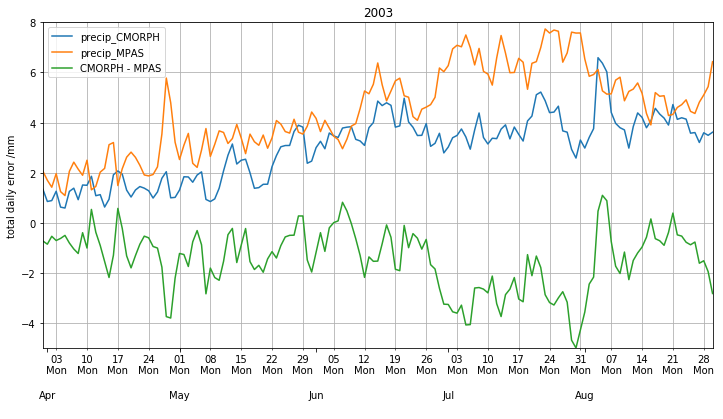

In [8]:
import matplotlib.dates as dates
# pd_plot = pd.concat([df_obs, df_mod,minus], axis=1)
plt.figure(figsize=(6,6))

ymin = -5.
ymax = 8.
idx = pd.date_range('2003-04-01', '2003-09-01')
# s = pd.Series(np.random.randn(len(idx)), index=idx)

# fig, ax = plt.subplots()
# ax.plot_date(idx.to_pydatetime(), 'v-')
ax = pd_plot.plot(figsize=(12,6))
ax.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0),
                                                interval=1))
ax.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
ax.xaxis.grid(True, which="minor")
ax.yaxis.grid()
ax.xaxis.set_major_locator(dates.MonthLocator())
ax.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n'))
# ax.set_xlim([xmin,xmax])
ax.set_ylim([ymin,ymax])
# plt.tight_layout()
# plt.show()
ax.set_ylabel("total daily error /mm")
plt.title(year)
# plt.savefig("./output_pic/precip_check_timeseries/"+year+"_time_series.png")

In [9]:
quantile_obs = precip_obs.quantile(np.linspace(0,1,101),dim=list(precip_obs.coords)[0:3])
quantile_mod = precip_mod.quantile(np.linspace(0,1,101),dim=list(precip_mod.coords)[0:3])
quantile_dict = {"quantile_obs":pd.Series(quantile_obs,index=np.linspace(0,1,101)), \
"mod_series":pd.Series(quantile_mod,index=np.linspace(0,1,101))}
quantile_df = pd.DataFrame(quantile_dict)
quantile_df.head()




,quantile_obs,mod_series
0.00,0.0,-0.015798
0.01,0.0,0.000000
0.02,0.0,0.000000
0.03,0.0,0.000000
0.04,0.0,0.000000


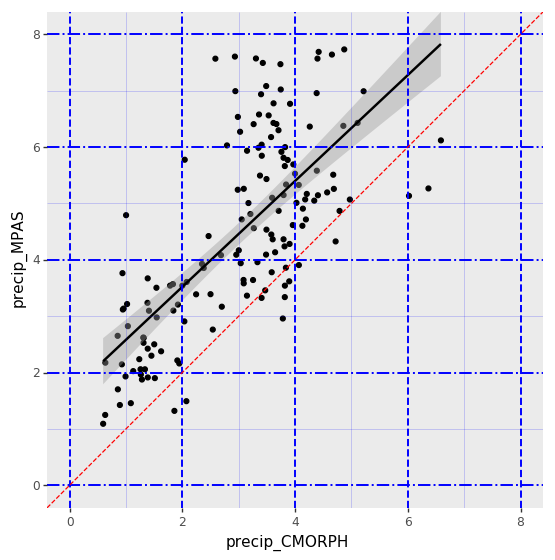

<ggplot: (2932296695630)>

In [10]:
from plotnine import *
from plotnine.data import *

ggplottest = (
    ggplot(pd_plot,aes(x='precip_CMORPH',y='precip_MPAS'))
    # + geom_density(alpha=0.1)
    + theme(
    panel_grid=element_line(color="blue"),

    panel_grid_major=element_line(size=1.4, alpha=1),
    panel_grid_major_x=element_line(linetype='dashed'),
    panel_grid_major_y=element_line(linetype='dashdot'),

    panel_grid_minor=element_line(alpha=.25),
    panel_grid_minor_x=element_line(color="blue"),
    panel_grid_minor_y=element_line(color="blue"),
    
    panel_ontop=False  # puts the points behind the grid
 )
    + geom_point()
    # + panel_grid()
    # + position_identity()
    # + geom_smooth(method='lm')
    + geom_smooth(method='lm', stat='stat_smooth', position='identity',
            na_rm=False, inherit_aes=True, show_legend=True,
            legend_fill_ratio=0.95)
    + xlab('precip_CMORPH')
    + ylab('precip_MPAS')
    + coord_fixed(ratio = 1,xlim=(0,8),ylim=(0,8))
    # + coord_cartesian(xlim=(0,8),ylim=(0,8),expand=True)
    # + xlim(0,8)
    # + ylim(0,8)
    # + panel_grid_major()
    # + geom_label(title='?')
    + geom_abline(intercept=0, slope=1,color='r',linetype="dashed")
)
ggplottest
# ggplottest.save(ggplot, format="png", path="./output_pic/precip_check_timeseries/")
# ggplottest.save("./output_pic/precip_check_timeseries/"+year+"_scatter.png", width=10, height=10, dpi=300)      

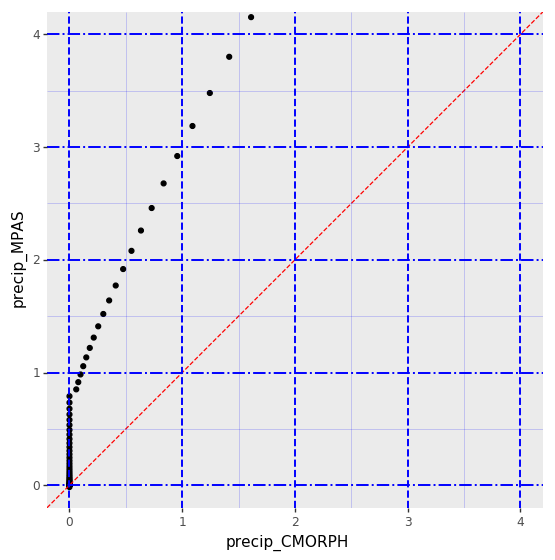

<ggplot: (-9223369104557832567)>

In [12]:
from plotnine import *
from plotnine.data import *
mpg.head()
ggplottest2 = (
    ggplot(quantile_df,aes(x='quantile_obs',y='mod_series'))
    # + geom_density(alpha=0.1)
    + theme(
    panel_grid=element_line(color="blue"),

    panel_grid_major=element_line(size=1.4, alpha=1),
    panel_grid_major_x=element_line(linetype='dashed'),
    panel_grid_major_y=element_line(linetype='dashdot'),

    panel_grid_minor=element_line(alpha=.25),
    panel_grid_minor_x=element_line(color="blue"),
    panel_grid_minor_y=element_line(color="blue"),

    panel_ontop=False  # puts the points behind the grid
 )
    + geom_point()
    # + panel_grid()
    # + position_identity()
    # + geom_smooth(method='lm')
    + xlab('precip_CMORPH')
    + ylab('precip_MPAS')
    + coord_fixed(ratio = 1,xlim=(0,4),ylim=(0,4))
    # + coord_cartesian(xlim=(0,8),ylim=(0,8),expand=True)
    # + xlim(0,8)
    # + ylim(0,8)
    # + panel_grid_major()
    + geom_abline(intercept=0, slope=1,color='r',linetype="dashed")      
)
ggplottest2
# ggplottest2.save("./output_pic/precip_check_timeseries/"+year+"_quantile.png", width=10, height=10, dpi=300)